<a href="https://colab.research.google.com/github/evangeliapant/Wildfire-Detection-using-Image-Analysis/blob/main/wildfire_mobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb --upgrade  # Make sure wandb is installed and up-to-date

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import os
import wandb
from PIL import Image
from wandb.integration.keras import WandbCallback

In [ ]:
# Initialize W&B
wandb.init(project="wildfire_detection")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set the base directory for your data in Google Drive
base_dir = '/content/drive/My Drive/data'
train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32  # Increased batch size for faster processing

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validate_generator = val_test_datagen.flow_from_directory(
    validate_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Clear session to avoid clutter from old models
tf.keras.backend.clear_session()

In [ ]:
# Load pre-trained MobileNetV2 model + higher level layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add top layers
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base_model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Verify class weights before training
print("Class weights (verified):", class_weights)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validate_generator.samples // batch_size
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

In [ ]:
# Model Training
checkpoint = ModelCheckpoint('models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validate_generator,
    validation_steps=validation_steps,
    epochs=5,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    class_weight=class_weights
)

In [ ]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validate_generator,
    validation_steps=validate_generator.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    class_weight=class_weights
)

In [ ]:
# Model Evaluation
best_model = tf.keras.models.load_model('models/best_model.keras')

# Ensure that the test set is fully covered
test_steps = np.ceil(test_generator.samples / batch_size).astype(int)

train_generator.reset()
train_loss, train_accuracy = best_model.evaluate(train_generator, steps=train_generator.samples // batch_size)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

validate_generator.reset()
val_loss, val_accuracy = best_model.evaluate(validate_generator, steps=validate_generator.samples // batch_size)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

test_generator.reset()
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

71/71 [==============================] - 131s 2s/step
Length of y_true: 2250
Length of y_pred_classes: 2250
Precision: 0.48
Recall: 0.40
F1 Score: 0.44
                precision    recall  f1-score   support

    fire_smoke       0.52      0.61      0.56      1171
nofire_nosmoke       0.48      0.40      0.44      1079

      accuracy                           0.51      2250
     macro avg       0.50      0.50      0.50      2250
  weighted avg       0.50      0.51      0.50      2250



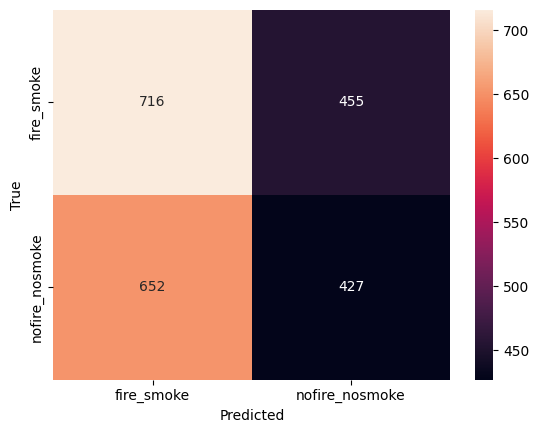

In [ ]:
# Predict on test data
test_generator.reset()
# Calculate the number of steps to ensure all samples are predicted
test_steps = np.ceil(test_generator.samples / batch_size).astype(int)

# Generate predictions for the test set
y_pred = best_model.predict(test_generator, steps=test_steps)
y_pred_classes = (y_pred > 0.5).astype("int32").reshape(-1)
y_true = test_generator.classes

# Ensure y_pred_classes and y_true have the same length
y_pred_classes = y_pred_classes[:len(y_true)]

# Check lengths for consistency
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_classes: {len(y_pred_classes)}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Classification report
target_names = list(test_generator.class_indices.keys())
classification_report_str = classification_report(y_true, y_pred_classes, target_names=target_names)
print(classification_report_str)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

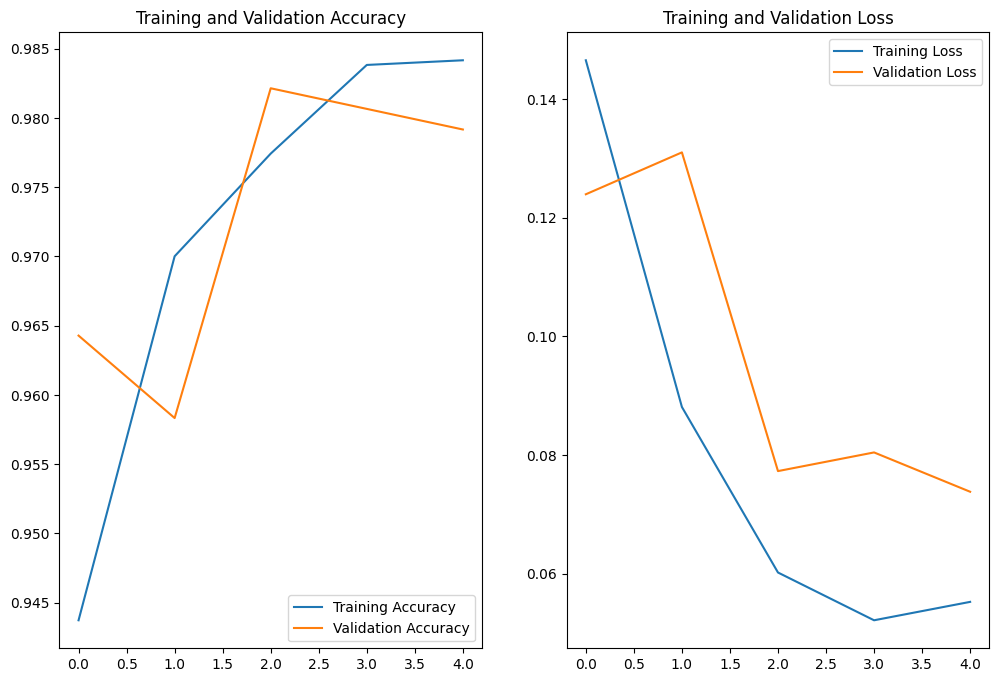

In [ ]:
# Plotting training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Plotting training history
acc = history.history['accuracy